In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install gdown

# to upgrade
# !pip install --upgrade gdown

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!gdown --id 1-1qz3wKuEhpn-3KqnWicxbz3LcKZ-bkg

In [ ]:
#!unzip ShenZhen.zip

In [ ]:
!nvidia-smi

Sun Jul 10 15:28:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |  14586MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import InputLayer, Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

tf.random.set_seed(
    seed = 42
)

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Data/ShenZhen'
TRAIN_PATH = f'{DATA_PATH}/train'
VALID_PATH = f'{DATA_PATH}/valid'
TEST_PATH = f'{DATA_PATH}/test'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
MAX_ACC = 0.95
BASE_LEARNING_RATE = 0.0001
VALID_RATIO = 0.1

# Load dataset

In [ ]:
data = pd.read_csv(f'{DATA_PATH}/shenzhen_metadata.csv')
del data["sex"]
del data["age"]

for index, row in data.iterrows():
  if row['findings']!='normal':
    row['findings']='abnormal'

data

,study_id,findings
0,CHNCXR_0001_0.png,normal
1,CHNCXR_0002_0.png,normal
2,CHNCXR_0003_0.png,normal
3,CHNCXR_0004_0.png,normal
4,CHNCXR_0005_0.png,normal
...,...,...
657,CHNCXR_0658_1.png,abnormal
658,CHNCXR_0659_1.png,abnormal
659,CHNCXR_0660_1.png,abnormal
660,CHNCXR_0661_1.png,abnormal


In [ ]:
labels = data['findings']
labels

0        normal
1        normal
2        normal
3        normal
4        normal
         ...   
657    abnormal
658    abnormal
659    abnormal
660    abnormal
661    abnormal
Name: findings, Length: 662, dtype: object

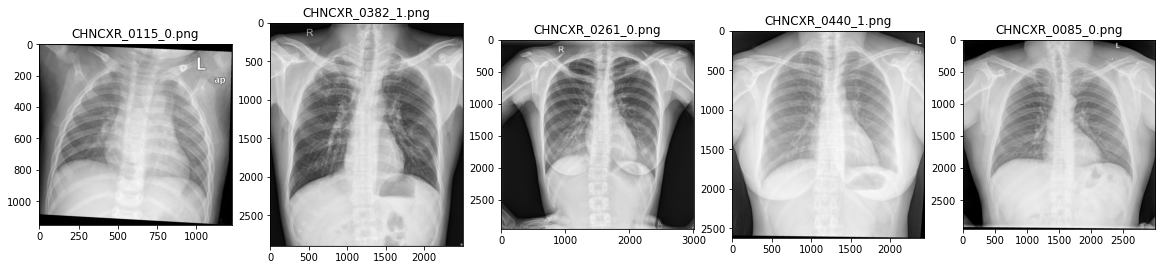

In [ ]:
plt.figure(figsize=(20,20))
test_folder=f'{DATA_PATH}/images'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# Visualize dataset

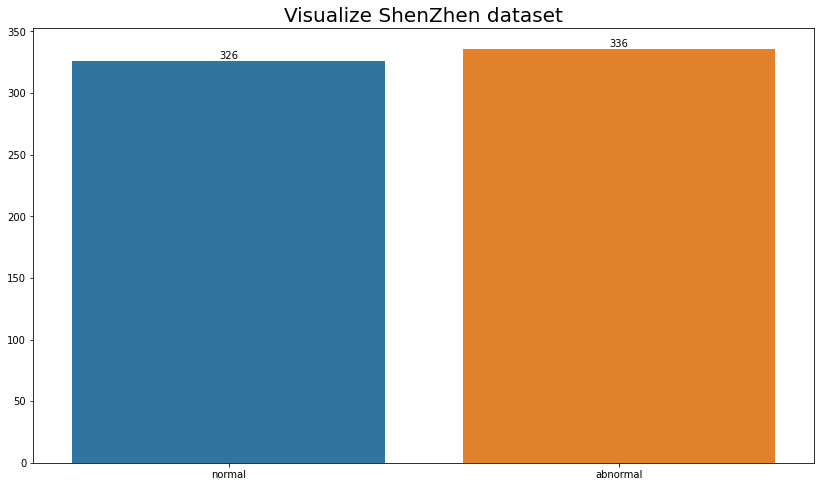

In [ ]:
counter = []
patient_status = []
fig, ax = plt.subplots(figsize =(14, 8))
plt.title("Visualize ShenZhen dataset", fontsize=20)
for i in labels:
  tmp = 0
  for j in range(len(patient_status)):
    if i == patient_status[j]:
      tmp = 1
      counter[j] = counter[j]+1
      break
  if tmp == 0:
    patient_status.append(i)
    counter.append(1)

sns.barplot(x = patient_status, y = counter)

for j in range(len(patient_status)):
  plt.text(j,counter[j],counter[j],ha="center",va="bottom")

# Split dataset

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=101, stratify=labels)
train_labels = train['findings']
train, valid = train_test_split(train, test_size=VALID_RATIO, random_state=101, stratify=train_labels)
print(train.shape)
print(test.shape)
print(valid.shape)

(476, 2)
(133, 2)
(53, 2)


In [ ]:
# Set the image_id as the index in df_data
data.set_index('study_id', inplace=True)
data

,findings
study_id,
CHNCXR_0001_0.png,normal
CHNCXR_0002_0.png,normal
CHNCXR_0003_0.png,normal
CHNCXR_0004_0.png,normal
CHNCXR_0005_0.png,normal
...,...
CHNCXR_0658_1.png,abnormal
CHNCXR_0659_1.png,abnormal
CHNCXR_0660_1.png,abnormal


In [ ]:
def augmentation(PATH, num_image):
  for item in patient_status:
    aug_dir = f'{DATA_PATH}/aug_dir'
    os.mkdir(aug_dir)
           
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    # list all images in that directory
    img_list = os.listdir(f'{PATH}/{img_class}')

    for fname in img_list:
      # source path to image
      src = os.path.join(f'{PATH}/{img_class}', fname)
      # destination path to image
      dst = os.path.join(img_dir, fname)
      # copy the image from the source to the destination
      shutil.copyfile(src, dst)

    path = aug_dir
    save_path = f'{PATH}/{img_class}'

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    
    aug_datagen = datagen.flow_from_directory(path,
                                            save_to_dir=save_path,
                                            save_format='png',
                                            target_size=IMAGE_SIZE,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((num_image - num_files)/BATCH_SIZE))

    # run the generator and create augmented images
    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree(f'{DATA_PATH}/aug_dir')

# Split image data into folder and generator number of train data

In [ ]:
if os.path.isdir(TRAIN_PATH) is False:
    # Create train, valid, test folders
    os.mkdir(TRAIN_PATH)
    os.mkdir(VALID_PATH)
    os.mkdir(TEST_PATH)

    train_list = list(train['study_id'])
    val_list = list(valid['study_id'])
    test_list = list(test['study_id'])

    #Create (normal, abnormal) folder
    for i in patient_status:
      os.mkdir(f'{TRAIN_PATH}/{i}')
      os.mkdir(f'{VALID_PATH}/{i}')
      os.mkdir(f'{TEST_PATH}/{i}')

    folder = os.listdir(f'{DATA_PATH}/images')

    for image in train_list:
    
      fname = image
      label = data.loc[image,'findings']
    
      if fname in folder:
        # source path to image
        src = os.path.join(f'{DATA_PATH}/images', fname)
        # destination path to image
        dst = os.path.join(TRAIN_PATH, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, IMAGE_SIZE)
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    for image in val_list:
    
      fname = image
      label = data.loc[image,'findings']
    
      if fname in folder:
        # source path to image
        src = os.path.join(f'{DATA_PATH}/images', fname)
        # destination path to image
        dst = os.path.join(VALID_PATH, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, IMAGE_SIZE)
        # save the image at the destination
        cv2.imwrite(dst, image)

    for image in test_list:
    
      fname = image
      label = data.loc[image,'findings']
    
      if fname in folder:
        # source path to image
        src = os.path.join(f'{DATA_PATH}/images', fname)
        # destination path to image
        dst = os.path.join(TEST_PATH, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, IMAGE_SIZE)
        # save the image at the destination
        cv2.imwrite(dst, image)
    
    augmentation(TRAIN_PATH, 500)

In [ ]:
for i in patient_status:
  print(len(os.listdir(f'{TRAIN_PATH}/{i}')))
  print(len(os.listdir(f'{VALID_PATH}/{i}')))
  print(len(os.listdir(f'{TEST_PATH}/{i}')))

502
26
65
514
27
68


In [ ]:
datagen = ImageDataGenerator()

train_data = datagen.flow_from_directory(TRAIN_PATH,
                                        target_size=IMAGE_SIZE,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

valid_data = datagen.flow_from_directory(VALID_PATH,
                                        target_size=IMAGE_SIZE,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

test_data = datagen.flow_from_directory(TEST_PATH,
                                        target_size=IMAGE_SIZE,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1016 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [ ]:
N_TRAIN_SAMPLE=len(train)
N_VALID_SAMPLE=len(valid)
N_TEST_SAMPLE=len(test)

# Add Resnet Model

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE
)

#fine-tuning
fine_tune_at = 140

for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False

resnet_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation='softmax')
])

resnet_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 average_pooling2d_36 (Avera  (None, 3, 3, 2048)       0         
 gePooling2D)                                                    
                                                                 
 average_pooling2d_37 (Avera  (None, 1, 1, 2048)       0         
 gePooling2D)                                                    
                                                                 
 flatten_18 (Flatten)        (None, 2048)              0         
                                                                 
 dense_54 (Dense)            (None, 64)                131136    
                                                                 
 dense_55 (Dense)            (None, 32)              

In [ ]:
# define a callback class
class myCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        if logs.get('val_accuracy') >= MAX_ACC:
            print(f'accuracy reached {MAX_ACC * 100}%. Stop learning')
            self.model.stop_training = True

callback = myCallBacks()
resnet_current_best = 0.84375
resnet_checkpoint = f'{DATA_PATH}/resnet/resnet_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=resnet_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=resnet_current_best)

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE/10),
              loss=['binary_crossentropy'],
              metrics=['accuracy']) 

resnet_model.fit(train_data,
          steps_per_epoch=(N_TRAIN_SAMPLE//BATCH_SIZE),
          epochs=200,
          validation_data = valid_data,
          validation_steps=(N_VALID_SAMPLE//BATCH_SIZE),
          callbacks=[callback, model_checkpoint_callback])

Epoch 1/200
14/14 [==============================] - 7s 229ms/step - loss: 2.8440e-04 - accuracy: 1.0000 - val_loss: 1.2518 - val_accuracy: 0.7812
Epoch 2/200
14/14 [==============================] - 2s 155ms/step - loss: 2.5166e-04 - accuracy: 1.0000 - val_loss: 1.2654 - val_accuracy: 0.7812
Epoch 3/200
14/14 [==============================] - 2s 155ms/step - loss: 2.6028e-04 - accuracy: 1.0000 - val_loss: 1.2961 - val_accuracy: 0.8125
Epoch 4/200
14/14 [==============================] - 2s 154ms/step - loss: 9.1388e-04 - accuracy: 1.0000 - val_loss: 1.8130 - val_accuracy: 0.6875
Epoch 5/200
14/14 [==============================] - 2s 155ms/step - loss: 0.0050 - accuracy: 0.9978 - val_loss: 1.9203 - val_accuracy: 0.7500
Epoch 6/200
14/14 [==============================] - 2s 155ms/step - loss: 0.0030 - accuracy: 0.9977 - val_loss: 2.3758 - val_accuracy: 0.6875
Epoch 7/200
14/14 [==============================] - 2s 157ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 1.9109 - val_

In [ ]:
resnet_model.load_weights(f'{DATA_PATH}/resnet/resnet_checkpoint')

In [ ]:
results = resnet_model.evaluate(valid_data, steps=(N_VALID_SAMPLE//BATCH_SIZE))

print("test loss, test acc:", results)

1/1 [==============================] - 0s 252ms/step - loss: 1.1604 - accuracy: 0.8438
test loss, test acc: [1.1603871583938599, 0.84375]


# Add Densenet Model

In [ ]:
densenet_current_best = 0.8359375
densenet_checkpoint = f'{DATA_PATH}/densenet/densenet_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=densenet_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
  initial_value_threshold=densenet_current_best)

In [ ]:
dense_pretrained_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE
)

fine_tune_at = 200

for layer in dense_pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False

densenet_model = tf.keras.Sequential([
    dense_pretrained_model,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation='softmax')
])

densenet_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d_40 (Avera  (None, 3, 3, 1024)       0         
 gePooling2D)                                                    
                                                                 
 average_pooling2d_41 (Avera  (None, 1, 1, 1024)       0         
 gePooling2D)                                                    
                                                                 
 flatten_20 (Flatten)        (None, 1024)              0         
                                                                 
 dense_60 (Dense)            (None, 64)                65600     
                                                                 
 dense_61 (Dense)            (None, 32)              

In [ ]:
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE/10),
              loss=['binary_crossentropy'],
              metrics=['accuracy']) 

densenet_model.fit(train_data,
          steps_per_epoch=(N_TRAIN_SAMPLE//BATCH_SIZE),
          epochs=200,
          validation_data = valid_data,
          validation_steps=(N_VALID_SAMPLE//BATCH_SIZE),
          callbacks=[callback, model_checkpoint_callback])

Epoch 1/200
14/14 [==============================] - 14s 389ms/step - loss: 0.7084 - accuracy: 0.5227 - val_loss: 0.6109 - val_accuracy: 0.7500
Epoch 2/200
14/14 [==============================] - 3s 233ms/step - loss: 0.6137 - accuracy: 0.7341 - val_loss: 0.5835 - val_accuracy: 0.8125
Epoch 3/200
14/14 [==============================] - 3s 177ms/step - loss: 0.5537 - accuracy: 0.8045 - val_loss: 0.5649 - val_accuracy: 0.8125
Epoch 4/200
14/14 [==============================] - 3s 232ms/step - loss: 0.5055 - accuracy: 0.8000 - val_loss: 0.5325 - val_accuracy: 0.8438
Epoch 5/200
14/14 [==============================] - 3s 180ms/step - loss: 0.4638 - accuracy: 0.8227 - val_loss: 0.5021 - val_accuracy: 0.8438
Epoch 6/200
14/14 [==============================] - 3s 181ms/step - loss: 0.4300 - accuracy: 0.8348 - val_loss: 0.4823 - val_accuracy: 0.8438
Epoch 7/200
14/14 [==============================] - 3s 180ms/step - loss: 0.3842 - accuracy: 0.8636 - val_loss: 0.4722 - val_accuracy: 0.812

In [ ]:
densenet_model.load_weights(densenet_checkpoint)

In [ ]:
results = densenet_model.evaluate(test_data,
                        steps=(N_TEST_SAMPLE//BATCH_SIZE))

print("test loss, test acc:", results)

4/4 [==============================] - 1s 120ms/step - loss: 0.6097 - accuracy: 0.8359
test loss, test acc: [0.6096922159194946, 0.8359375]


# Add VGG Model

In [ ]:
vgg_current_best = 0.875
vgg_checkpoint = f'{DATA_PATH}/vgg/vgg_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=vgg_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=vgg_current_best)

In [ ]:
vgg_pretrained_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SHAPE
)

vgg_model = tf.keras.Sequential([
    vgg_pretrained_model,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(2, activation='softmax')
])

vgg_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d_42 (Avera  (None, 3, 3, 512)        0         
 gePooling2D)                                                    
                                                                 
 average_pooling2d_43 (Avera  (None, 1, 1, 512)        0         
 gePooling2D)                                                    
                                                                 
 flatten_21 (Flatten)        (None, 512)               0         
                                                                 
 dense_63 (Dense)            (None, 64)                32832     
                                                                 
 dense_64 (Dense)            (None, 32)              

In [ ]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
              loss=['binary_crossentropy'],
              metrics=['accuracy']) 

vgg_model.fit(train_data,
          steps_per_epoch=(N_TRAIN_SAMPLE//BATCH_SIZE),
          epochs=200,
          validation_data = valid_data,
          validation_steps=(N_VALID_SAMPLE//BATCH_SIZE),
          callbacks=[callback, model_checkpoint_callback])

Epoch 1/200
14/14 [==============================] - 10s 518ms/step - loss: 0.9309 - accuracy: 0.5545 - val_loss: 0.8415 - val_accuracy: 0.1562
Epoch 2/200
14/14 [==============================] - 7s 464ms/step - loss: 0.6741 - accuracy: 0.5558 - val_loss: 0.9871 - val_accuracy: 0.1562
Epoch 3/200
14/14 [==============================] - 7s 501ms/step - loss: 0.6874 - accuracy: 0.6250 - val_loss: 0.4481 - val_accuracy: 0.7500
Epoch 4/200
14/14 [==============================] - 7s 474ms/step - loss: 0.6796 - accuracy: 0.5737 - val_loss: 0.7970 - val_accuracy: 0.1562
Epoch 5/200
14/14 [==============================] - 7s 520ms/step - loss: 0.5985 - accuracy: 0.7031 - val_loss: 0.3972 - val_accuracy: 0.7812
Epoch 6/200
14/14 [==============================] - 7s 525ms/step - loss: 0.5204 - accuracy: 0.7614 - val_loss: 0.3934 - val_accuracy: 0.8125
Epoch 7/200
14/14 [==============================] - 7s 464ms/step - loss: 0.4898 - accuracy: 0.7768 - val_loss: 0.4632 - val_accuracy: 0.750

In [ ]:
vgg_model.load_weights(vgg_checkpoint)

In [ ]:
results = vgg_model.evaluate(test_data,
                        steps=(N_TEST_SAMPLE//BATCH_SIZE))

print("test loss, test acc:", results)

4/4 [==============================] - 1s 160ms/step - loss: 0.4762 - accuracy: 0.8750
test loss, test acc: [0.4761549234390259, 0.875]


# Caculate four evaluation metrics: accuracy

In [ ]:
from sklearn.metrics import accuracy_score
y_true = test_data.labels

def get_y_pred(model):
  test_pred = model.predict(test_data)
  result = []
  for i in range(len(test_pred)):
    if test_pred[i][0] >= test_pred[i][1]:
      result.append(0)
    else: 
      result.append(1)
  y_pred = np.array(result)
  return y_pred


def get_evaluation(y_true, model):
  y_pred = get_y_pred(model)
  metric = [accuracy_score(y_true, y_pred)]
  return metric


A=[]
resnet_metrics = get_evaluation(y_true, resnet_model)
A.append(resnet_metrics)
densenet_metrics = get_evaluation(y_true, densenet_model)
A.append(densenet_metrics)
vgg_metrics = get_evaluation(y_true, vgg_model)
A.append(vgg_metrics)
A

[[0.5037593984962406], [0.8345864661654135], [0.8571428571428571]]

# Caculate weight w

In [ ]:
def caculate_w(model_metrics):
  result = 0
  for i in model_metrics:
    result = result + np.tanh(i)
  return result

W = []
W.append(caculate_w(resnet_metrics))
W.append(caculate_w(densenet_metrics))
W.append(caculate_w(vgg_metrics))
W

[0.46506858631426673, 0.6829310408220373, 0.6947826703147378]

# Caculate ensemble probability score

In [ ]:
resnet_pred = resnet_model.predict(test_data)
densenet_pred = densenet_model.predict(test_data)
vgg_pred = vgg_model.predict(test_data)

def caculate_ensemble(resnet_pred, densenet_pred, vgg_pred, test):
  ensemble_prob = []
  for i in range(len(test)):
    p = []
    tmp = resnet_pred[i][0]*W[0] + densenet_pred[i][0]*W[1] + vgg_pred[i][0]*W[2]
    tmp1 = tmp / (W[0] + W[1] + W[2])
    p.append(tmp1)

    tmp = resnet_pred[i][1]*W[0] + densenet_pred[i][1]*W[1] + vgg_pred[i][1]*W[2]
    tmp1 = tmp / (W[0] + W[1] + W[2])
    p.append(tmp1)
    ensemble_prob.append(p)
  return ensemble_prob

ensemble_prob = caculate_ensemble(resnet_pred, densenet_pred, vgg_pred, test)
ensemble_prob

[[0.9930946793464529, 0.006905329680739876],
 [0.9978288797186627, 0.002171146064257433],
 [0.9471546439091225, 0.052845350981402237],
 [0.2970396947466031, 0.7029603225950991],
 [0.9150715146410371, 0.08492851322517829],
 [0.9959387540261094, 0.004061236864137307],
 [0.23970052643267734, 0.7602994513907685],
 [0.9968275254265038, 0.0031724443351346925],
 [0.9922597824454944, 0.007740231738244497],
 [0.9948982753341603, 0.005101746923313786],
 [0.6187306296662909, 0.38126936476604295],
 [0.6103863719713815, 0.38961362269710165],
 [0.9961349714078456, 0.003865024382634912],
 [0.9923866953004054, 0.007613329053064889],
 [0.9243895385034724, 0.0756104692660224],
 [0.5857842723619953, 0.414215729845499],
 [0.9975904894749997, 0.0024095045530532003],
 [0.9863699346405682, 0.01363006093990849],
 [0.9956597912394802, 0.0043401960988858415],
 [0.4819697052203674, 0.518030300230059],
 [0.9133239472102225, 0.08667607067820539],
 [0.9810440829046165, 0.018955932468759925],
 [0.9858263931518573, 0

In [ ]:
result = []
for i in range(len(ensemble_prob)):
  if ensemble_prob[i][0] >= ensemble_prob[i][1]:
    result.append(0)
  else: 
    result.append(1)

results = np.array(result)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_true, results))

Accuracy: 0.8270676691729323


In [ ]:
#accuracy for normal, abnormal 
count = 0
sum = 0
#x=0 -> abnormal
x = 0
for i in range(len(results)):
  if y_true[i] == x:
    sum+=1
    if results[i] == x:
      count+=1
print(count/sum)

In [ ]:
#get number of image
def getNum(label):
  l = label.split("_")
  num = int(l[1])
  return num

#result combine number of image and prediction
def newResult(test_data):
  result = []
  for i in range(len(test_data.filenames)):
    num = getNum(test_data.filenames[i])
    tmp = [num, results[i]]
    result.append(tmp)
  return result

new_result = newResult(test_data)

In [ ]:
plt.figure(figsize=(20,20))
test_folder=f'{DATA_PATH}/test/normal'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    num = getNum(image_path)
    for j in new_result:
      if num == j[0]:
        label = j[1]
        break
    if label == 0:
      status = 'abnormal'
    else: 
      status = 'normal'

    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title(status)
    plt.xlabel(file)
    plt.imshow(img)


plt.figure(figsize=(20,20))
test_folder=f'{DATA_PATH}/test/abnormal'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    num = getNum(image_path)
    for j in new_result:
      if num == j[0]:
        label = j[1]
        break
    if label == 0:
      status = 'abnormal'
    else: 
      status = 'normal'

    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title(status)
    plt.xlabel(file)
    plt.imshow(img)

FileNotFoundError: ignored

<Figure size 1440x1440 with 0 Axes>